In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [191]:
# загружаем данные и разбиваем их на составляющие
train = pd.read_csv("./train.csv")
y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

In [192]:

X_train = normalize(X_train.astype('float32'), axis=1)

# Из файла информацию о изображения с цифрами мы получили в виде одномерных векторов из 784 значений
# Переформируем все данные в трехмерные матрицы 28x28x1.
# Keras требует дополнительное измерение в конце, для каналов. 
# Если бы это были RGB-изображения, то было бы 3 канала, но поскольку у нас "черно-белое" изображение, мы указываем 1 серый канал.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

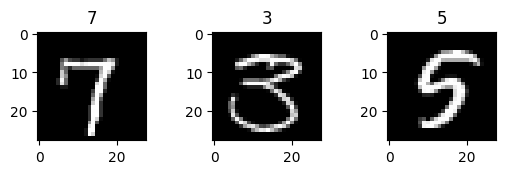

In [193]:
# убедимся, что все ок, выведем сами тестовые изображения и соответствующие им цифры 
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

In [194]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

# Нормализуем данные
def normalize(x): 
    return (x-mean_px)/std_px

Метки в данном случае представлены целыми числами от 0 до 9. 
Нам нужно применить one-hot encoding, чтобы преобразовать эти one-hot числовой массив (например: 2 -> [0,0,1,0,0,0,0,0,0,0,0]).

In [195]:
print(f"{y_train[0]} преобрауется в ")
y_train = to_categorical(y_train, num_classes = 10)
# Пример:
print(y_train[0])

1 преобрауется в 
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [196]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save weights
checkpoint_callback = ModelCheckpoint(
    filepath='weights.{epoch:02d}.h5',
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [197]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)


In [198]:
model = Sequential()
model.add(Lambda(normalize,input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(128, activation='relu')),
model.add(Dense(128, activation='relu')),
model.add(Dense(10, activation='softmax'))

In [199]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [200]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=30, 
                    verbose=1,
                    validation_data=(X_test, y_test), callbacks=[checkpoint_callback])

loss, accuracy = model.evaluate(X_test, y_test)

print(f"Final loss: {loss}")
print(f"Final accuracy: {accuracy}")


Epoch 1/30
2100/2100 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.8459
Epoch 1: saving model to weights.01.h5
2100/2100 [==============================] - 15s 7ms/step - loss: 0.4841 - accuracy: 0.8459 - val_loss: 0.1864 - val_accuracy: 0.9383
Epoch 2/30
2096/2100 [============================>.] - ETA: 0s - loss: 0.2551 - accuracy: 0.9193
Epoch 2: saving model to weights.02.h5
2100/2100 [==============================] - 14s 7ms/step - loss: 0.2552 - accuracy: 0.9193 - val_loss: 0.2061 - val_accuracy: 0.9337
Epoch 3/30
2098/2100 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9349
Epoch 3: saving model to weights.03.h5
2100/2100 [==============================] - 16s 8ms/step - loss: 0.2124 - accuracy: 0.9349 - val_loss: 0.1172 - val_accuracy: 0.9630
Epoch 4/30
2095/2100 [============================>.] - ETA: 0s - loss: 0.1921 - accuracy: 0.9399
Epoch 4: saving model to weights.04.h5
2100/2100 [==============================] - 14s 7

In [201]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Посмотрим, как происходило изменение точности на каждой из эпох

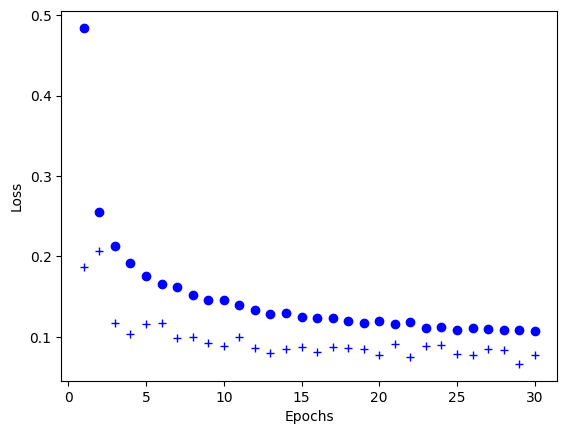

In [202]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

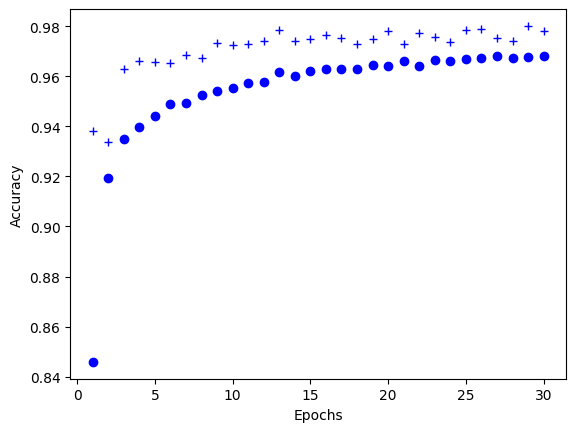

In [203]:
plt.clf() # clear
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

### градиент целевой функции по обучаемым параметрам нейронной сети

In [204]:
# Calculate gradients using tf.GradientTape
with tf.GradientTape() as tape:
    y_pred = model(X_test)
    loss_value = tf.keras.losses.categorical_crossentropy(y_test, y_pred)

# Calculate gradients of loss with respect to model trainable variables
gradients = tape.gradient(loss_value, model.trainable_variables)

# Print the gradients
for var, grad in zip(model.trainable_variables, gradients):
    print(f"Variable: {var.name}, Gradient shape: {grad.shape}")
    print(grad.numpy())

Variable: dense_29/kernel:0, Gradient shape: (784, 128)
[[ 0.1330024  -4.440092   -0.6854059  ...  0.11676839  0.9746438
   0.29099798]
 [ 0.1330024  -4.440092   -0.6854059  ...  0.11676839  0.9746438
   0.29099798]
 [ 0.1330024  -4.440092   -0.6854059  ...  0.11676839  0.9746438
   0.29099798]
 ...
 [ 0.1330024  -4.440092   -0.6854059  ...  0.11676839  0.9746438
   0.29099798]
 [ 0.1330024  -4.440092   -0.6854059  ...  0.11676839  0.9746438
   0.29099798]
 [ 0.1330024  -4.440092   -0.6854059  ...  0.11676839  0.9746438
   0.29099798]]
Variable: dense_29/bias:0, Gradient shape: (128,)
[-3.17261487e-01  1.05913191e+01  1.63495481e+00  3.56039181e-02
  1.75576672e-01 -7.14331269e-01  9.78976011e-01  1.70222497e+00
  1.58386087e+00  2.26797327e-01  1.37818909e+00 -1.79760635e-01
 -1.40424585e+00 -1.80058837e+00  1.66997790e-01 -2.72190675e-07
  2.72696495e+00 -7.21729994e-01 -3.09527493e+00  1.25915301e+00
  5.63342750e-01  2.03933522e-01 -9.95080054e-01  1.32732129e+00
 -1.70658076e+00  

### параметры нейронной сети, при которых точность классификации максимальна

Чтобы определить параметры нейронной сети, при которых точность классификации максимальна, мы
- должны проанализировать объект history, возвращаемый методом fit(), который содержит историю обучения, включая значения точности для каждой эпохи;
- найти эпоху с лучшей точностью проверки;
- по мере обучения модели мы сохраняем веса, полученные на каждой эпохе, в отдельный файл. Загрузим веса из файла соответсвующего эпохе с лучшей точностью;
- используем model.get_weights() для получения параметров (весов и смещений) модели в лучшую эпоху. Мы перебираем параметры и выводим их формы, чтобы проверить размеры параметров каждого слоя.

In [205]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])
best_accuracy = history.history['val_accuracy'][best_epoch]

# Load the weights of the model at the best epoch
model.load_weights(f'weights.{best_epoch+1:02d}.h5')

# Get the parameters of the model at the best epoch
best_parameters = model.get_weights()

# Print the best accuracy and parameters
print(f"Лучшая точность: {best_accuracy}")
print("Лучшие праметры:")
for layer_param in best_parameters:
    print(layer_param.shape)

print('\n')
print("Описание модели:")
model.summary()

Лучшая точность: 0.9801190495491028
Лучшие праметры:
(784, 128)
(128,)
(128, 128)
(128,)
(128, 10)
(10,)


Описание модели:
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_10 (Lambda)          (None, 28, 28, 1)         0         
                                                                 
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               100480    
                                                                 
 dense_30 (Dense)            (None, 128)               16512     
                                                                 
 dense_31 (Dense)            (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (46